In [30]:
import arff
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
with open('ThoraricSurgery.arff', 'r') as file:
    raw_data = arff.load(file)

In [4]:
df = pd.DataFrame(raw_data['data'], columns=[attr[0] for attr in raw_data['attributes']])
df.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60.0,F
1,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51.0,F
2,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59.0,F
3,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54.0,F
4,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73.0,T


In [5]:
print(df.shape)

(470, 17)


In [6]:
print(df.dtypes)

DGN         object
PRE4       float64
PRE5       float64
PRE6        object
PRE7        object
PRE8        object
PRE9        object
PRE10       object
PRE11       object
PRE14       object
PRE17       object
PRE19       object
PRE25       object
PRE30       object
PRE32       object
AGE        float64
Risk1Yr     object
dtype: object


In [7]:
# Check missing data
df.isnull().sum()

DGN        0
PRE4       0
PRE5       0
PRE6       0
PRE7       0
PRE8       0
PRE9       0
PRE10      0
PRE11      0
PRE14      0
PRE17      0
PRE19      0
PRE25      0
PRE30      0
PRE32      0
AGE        0
Risk1Yr    0
dtype: int64

In [8]:
# Checking outcome variable is binary as described in the metadata
df.Risk1Yr.unique()

array(['F', 'T'], dtype=object)

In [9]:
# Convert 'object' variable to categorical data and T/F into boolean data. 

df[['PRE6', 'PRE14', 'DGN']] = df[['PRE6', 'PRE14', 'DGN']].astype('category')

df = df.replace({'T': True, 'F': False})

/tmp/ipykernel_5336/1530268057.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'T': True, 'F': False})


In [10]:
df.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,DGN2,2.88,2.16,PRZ1,False,False,False,True,True,OC14,False,False,False,True,False,60.0,False
1,DGN3,3.40,1.88,PRZ0,False,False,False,False,False,OC12,False,False,False,True,False,51.0,False
2,DGN3,2.76,2.08,PRZ1,False,False,False,True,False,OC11,False,False,False,True,False,59.0,False
3,DGN3,3.68,3.04,PRZ0,False,False,False,False,False,OC11,False,False,False,False,False,54.0,False
4,DGN3,2.44,0.96,PRZ2,False,True,False,True,True,OC11,False,False,False,True,False,73.0,True


In [11]:
df.dtypes

DGN        category
PRE4        float64
PRE5        float64
PRE6       category
PRE7           bool
PRE8           bool
PRE9           bool
PRE10          bool
PRE11          bool
PRE14      category
PRE17          bool
PRE19          bool
PRE25          bool
PRE30          bool
PRE32          bool
AGE         float64
Risk1Yr        bool
dtype: object

In [12]:
# check outcome catgory balance (if need to split with stratification)
sum(df['Risk1Yr'])/len(df['Risk1Yr'])

0.14893617021276595

In [13]:
# Splilt dataframe
X = df.drop('Risk1Yr', axis=1).copy() 
y = df['Risk1Yr'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [14]:
sum(y==False)/sum(y==True)

5.714285714285714

In [15]:
clf_xgb = xgb.XGBClassifier(enable_categorical=True,
                        tree_method = 'hist',
                    eval_metric= 'aucpr',
                    early_stopping_rounds=20,
                    scale_pos_weight= sum(y==False)/sum(y==True)
                    )

clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.24755
[1]	validation_0-aucpr:0.30092
[2]	validation_0-aucpr:0.28473
[3]	validation_0-aucpr:0.30373
[4]	validation_0-aucpr:0.37329
[5]	validation_0-aucpr:0.40580
[6]	validation_0-aucpr:0.36651
[7]	validation_0-aucpr:0.39241
[8]	validation_0-aucpr:0.41147
[9]	validation_0-aucpr:0.40423
[10]	validation_0-aucpr:0.40582
[11]	validation_0-aucpr:0.40476
[12]	validation_0-aucpr:0.37808
[13]	validation_0-aucpr:0.40190
[14]	validation_0-aucpr:0.39152
[15]	validation_0-aucpr:0.38945
[16]	validation_0-aucpr:0.40887
[17]	validation_0-aucpr:0.38660
[18]	validation_0-aucpr:0.42231
[19]	validation_0-aucpr:0.40069
[20]	validation_0-aucpr:0.38561
[21]	validation_0-aucpr:0.38692
[22]	validation_0-aucpr:0.38488
[23]	validation_0-aucpr:0.38789
[24]	validation_0-aucpr:0.38192
[25]	validation_0-aucpr:0.41701
[26]	validation_0-aucpr:0.40491
[27]	validation_0-aucpr:0.39382
[28]	validation_0-aucpr:0.38485
[29]	validation_0-aucpr:0.37023
[30]	validation_0-aucpr:0.37169
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
clf_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, clf_pred)
print(cm)
accuracy = accuracy_score(y_test, clf_pred)
print(accuracy)

[[96  4]
 [13  5]]
0.8559322033898306


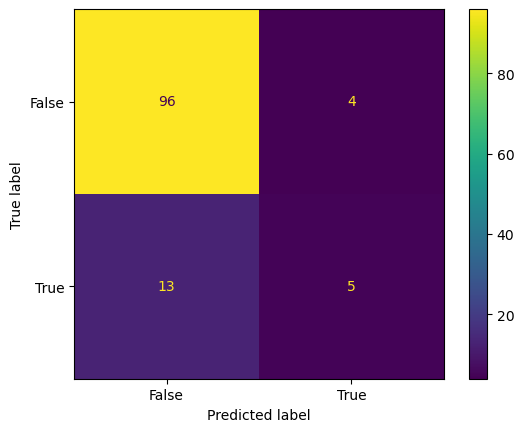

In [17]:
# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      values_format='d'
                                      )

In [21]:
clf_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, clf_pred)
print(cm)
accuracy = accuracy_score(y_test, clf_pred)
print(accuracy)

[[100   0]
 [ 18   0]]
0.847457627118644


In [18]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}


optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(#objective='binary:logistic', 
                                eval_metric="logloss", ## this avoids a warning...
                                subsample=0.9,
                                enable_categorical=True,
                                tree_method = 'hist',
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc', #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=0,
    n_jobs = 10,
    cv = 3
)

optimal_params.estimator.set_params(**{"eval_metric":"auc", "early_stopping_rounds":10})


optimal_params.fit(X_train, 
                   y_train, 
                   # early_stopping_rounds=10,                
                   # eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)


print(optimal_params.best_params_)


{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 10.0}


In [24]:
clf_xgb = xgb.XGBClassifier(
                            gamma=1.0,
                            learning_rate=0.01,
                            max_depth=3,
                            reg_lambda=10.0,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=20,
                            eval_metric='aucpr',
                            enable_categorical=True,
                            tree_method = 'hist',
                            scale_pos_weight= sum(y==False)/sum(y==True))
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.22407
[1]	validation_0-aucpr:0.34523
[2]	validation_0-aucpr:0.27809
[3]	validation_0-aucpr:0.29567
[4]	validation_0-aucpr:0.29856
[5]	validation_0-aucpr:0.29573
[6]	validation_0-aucpr:0.23671
[7]	validation_0-aucpr:0.23572
[8]	validation_0-aucpr:0.23491
[9]	validation_0-aucpr:0.19049
[10]	validation_0-aucpr:0.20165
[11]	validation_0-aucpr:0.21449
[12]	validation_0-aucpr:0.20259
[13]	validation_0-aucpr:0.20570
[14]	validation_0-aucpr:0.20671
[15]	validation_0-aucpr:0.21556
[16]	validation_0-aucpr:0.21417
[17]	validation_0-aucpr:0.21381
[18]	validation_0-aucpr:0.21388
[19]	validation_0-aucpr:0.21647
[20]	validation_0-aucpr:0.21459


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=20,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
clf_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, clf_pred)
print(cm)
accuracy = accuracy_score(y_test, clf_pred)
print(accuracy)

[[100   0]
 [ 16   2]]
0.864406779661017


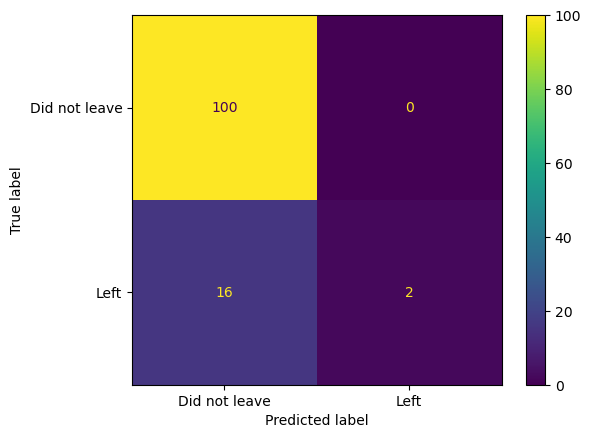

In [26]:
# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      values_format='d',
                                      display_labels=["Did not leave", "Left"])

weight:  {'DGN': 15.0, 'PRE4': 11.0, 'PRE5': 19.0, 'PRE6': 4.0, 'PRE7': 11.0, 'PRE8': 1.0, 'PRE9': 1.0, 'PRE10': 2.0, 'PRE11': 7.0, 'PRE14': 16.0, 'PRE17': 3.0, 'PRE30': 8.0, 'AGE': 18.0}
gain:  {'DGN': 17.222436904907227, 'PRE4': 6.221967697143555, 'PRE5': 6.3608317375183105, 'PRE6': 7.724904537200928, 'PRE7': 5.730120658874512, 'PRE8': 3.8426456451416016, 'PRE9': 4.445568084716797, 'PRE10': 8.607008934020996, 'PRE11': 9.840599060058594, 'PRE14': 10.501973152160645, 'PRE17': 5.710899353027344, 'PRE30': 8.436479568481445, 'AGE': 6.227184295654297}
cover:  {'DGN': 124.09851837158203, 'PRE4': 56.59751892089844, 'PRE5': 51.491573333740234, 'PRE6': 100.79421997070312, 'PRE7': 41.051090240478516, 'PRE8': 76.14111328125, 'PRE9': 12.661706924438477, 'PRE10': 118.78230285644531, 'PRE11': 83.22716522216797, 'PRE14': 89.1244888305664, 'PRE17': 76.39399719238281, 'PRE30': 91.44903564453125, 'AGE': 44.63929748535156}
total_gain:  {'DGN': 258.3365478515625, 'PRE4': 68.44164276123047, 'PRE5': 120.85

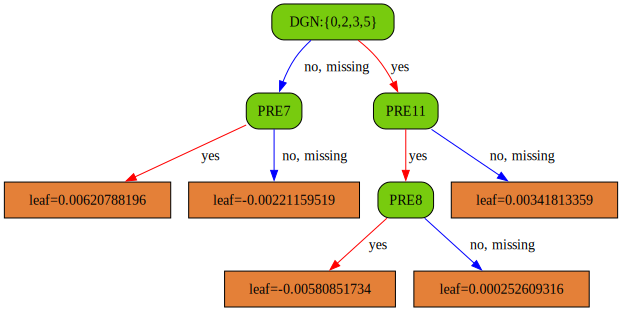

In [28]:
# Draw averga of total trees.
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, 
                condition_node_params=node_params,
                leaf_node_params=leaf_params) 

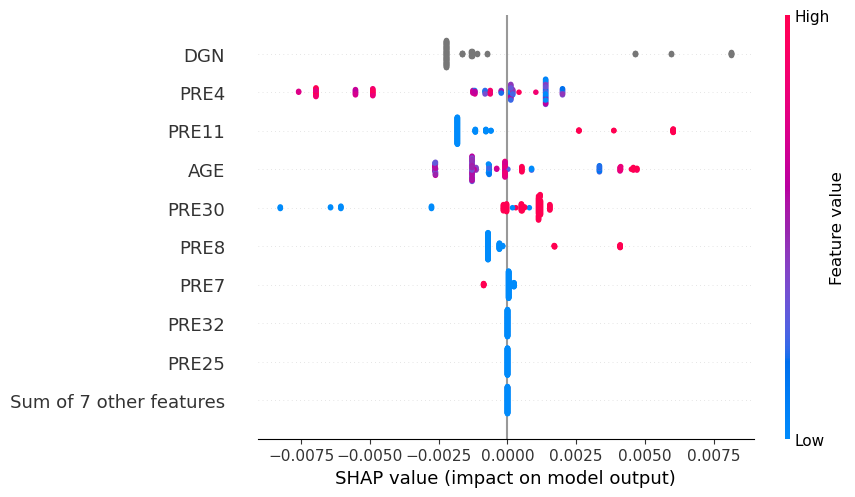

In [32]:
# Features importance to the model
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)